In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler 
from numpy import asarray
from numpy import percentile
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from IPython.display import Image
from six import StringIO
from sklearn import tree
import pydotplus
import pydot

In [2]:
# This class is used for personal and other dataset
class MySpritClass(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        for column_name in X:
            if X[column_name].dtypes == 'object':
                X[column_name] = X[column_name].str.strip()
        return X

# This class is used for other dataset    
class MyAdjustClass(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X['marital-status'] = X['marital-status'].replace('??', np.nan)
        X['occupation'] = X['occupation'].replace('?', np.nan)
        X['pregnant'] = X['pregnant'].replace(['f', 'F', 'FALSE'], 'False')
        X['pregnant'] = X['pregnant'].replace(['t', 'T', 'TRUE'], 'True')
        X['relationship'] = X['relationship'].replace('Not_in_family', 'Not-in-family')
        X['relationship'] = X['relationship'].replace('Own_child', 'Own-child')
        X['relationship'] = X['relationship'].replace('Other_relative', 'Other-relative')
        X['native-country'] = X['native-country'].replace('?', np.nan)
        X['workclass'] = X['workclass'].replace('?', np.nan)
        
        return X

# This class is used for other dataset
class SeparateAndDeleteMedicalInfo(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X = self.separate_and_delete_medical_info(X)
        return X
    
    def separate_and_delete_medical_info(self, dataframe):
        df2 = pd.DataFrame() 
        # Iterate through every row and take values from medical_info column
        for _,column_data in dataframe['medical_info'].iteritems(): 
            if isinstance(column_data, str): # If value isn't nan
                column_data = column_data[1:-1] # Delect curly brackets from start and end of string
                column_data_split = column_data.split(',') # Split string by comma

                row = {} 
                for name_value in column_data_split: # Iterate through split string
                    name_value_split = name_value.split(':') # Split into name of column and value of column
                    # Store value into dictionary with name of the column as a key
                    row[name_value_split[0][1:-1]] = [np.float(name_value_split[1][1:-1])] # Get rid of '' by [1:-1]

                row_data_frame = pd.DataFrame(row) # Convert dictionary into DataFrame
                df2 = df2.append(row_data_frame, ignore_index=True) # Append row_data_frame into df2
            else: # Value is nan, append nan row into df2
                df2 = df2.append(pd.Series(np.nan), ignore_index=True)

        df2 = df2.drop(columns=[0]) # Drop last column

        # Add values from df2 to main df
        for column_name in df2.columns:
            dataframe[column_name] = df2[column_name]

        del dataframe['medical_info'] # medical info is already divided into another columns, so we can erase it

        return dataframe

# This class is used for personal dataset
class SeparateAndDeleteAddress(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X = self.separate_and_delete_address(X)
        return X
    
    def separate_and_delete_address(self, dataframe):
        df_addresses = dataframe['address'].replace('\r', ',', regex=True)
        df_addresses = df_addresses.replace('\n', ' ', regex=True)
        df_addresses = df_addresses.str.split(',')

        cities = []
        streets = []
        zip_codes = []

        for address in df_addresses:
            if len(address) < 3: # these records have cities in address
                streets.append(address[0])
                cities.append(None)
                zip_codes.append(address[1])
            else: # these records don't have cities in address
                streets.append(address[0])
                cities.append(address[1])
                zip_codes.append(address[2])

        dataframe['street'] = streets
        dataframe['city'] = cities
        dataframe['zip_code'] = zip_codes

        dataframe = dataframe.drop('address', axis=1)

        return dataframe
    
# This class is used for joined dataset    
class DropDuplicates(BaseEstimator, TransformerMixin): 
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X = self.drop_duplicates(X)
        return X
    
    def drop_duplicates(self, data_frame):
        df1 = data_frame[data_frame.duplicated('name', keep=False)].sort_values('name')

        names = df1['name'].unique() # Get all unique names from duplicates

        # Check odd duplicates
        for name in names:
            number_of_duplicates = df1[df1['name'] == name]
            # Get Odd duplicates
            if len(number_of_duplicates) % 2 != 0:
                # Odd duplicates have different loop, that the even ones.
                for i in range(1, len(number_of_duplicates)): # We start from index one, each iteration we one index back a check NaNs
                    for (column_name1, column_data1), (_, column_data2) in zip(df1.iloc[i].iteritems(), df1.iloc[i - 1].iteritems()):
                        if pd.isnull(column_data1):
                            data_frame.loc[df1.iloc[i]['name'] == data_frame['name'], column_name1] = column_data2
                        else:
                            data_frame.loc[df1.iloc[i]['name'] == data_frame['name'], column_name1] = column_data1
                # From df1 dataset we drop solved odd duplicates
                df1.drop(df1[df1['name'] == 'Joseph Dehaven'].index, inplace = True)

        # Solve even duplicates
        for i in range(0,len(df1.index),2):
            for (column_name1, column_data1), (_, column_data2) in zip(df1.iloc[i].iteritems(), df1.iloc[i + 1].iteritems()):
                if pd.isnull(column_data1):
                    data_frame.loc[df1.iloc[i]['name'] == data_frame['name'], column_name1] = column_data2
                else:
                    data_frame.loc[df1.iloc[i]['name'] == data_frame['name'], column_name1] = column_data1

        data_frame = data_frame.drop_duplicates()

        return data_frame
    
# This class is used for joined dataset    
class ExtractYear(BaseEstimator, TransformerMixin): 
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X = self.extract_year(X)
        return X
    
    def extract_year(self, data_frame):
        years = []
        for cell in data_frame['date_of_birth']:
            if re.match('^[0-9]{2}\-[0-9]{2}\-[0-9]{2}$', cell):
                year = cell[:2]
                years.append(int('19' + year))
            elif re.match('[0-9]{4}', cell):
                years.append(int(re.findall('[0-9]{4}', cell)[0]))
            elif re.match('^[0-9]{2}\/[0-9]{2}\/[0-9]{4}$', cell):
                years.append(int(cell[-4:]))

        data_frame['year_of_birth'] = years

        return data_frame.drop(columns=['date_of_birth'])
    
# This class is used for joined dataset    
class CalculateAgeFromYear(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X = self.calculate_age_from_year(X)
        return X
    
    def calculate_age_from_year(self, data_frame):
        df = data_frame.dropna()
        # Calculate year, when data was recorder
        recording_year = df.iloc[0]['year_of_birth'] + df.iloc[0]['age'] 
        
        new_age = []
        for (age, data1), (year, data2) in zip(data_frame['age'].iteritems(), data_frame['year_of_birth'].iteritems()):
            if pd.isnull(data1):
                new_age.append(recording_year - data2) # There used to be 2020
            else:
                new_age.append(data1)

        data_frame['age'] = new_age

        return data_frame
    
# This class is used for joined dataset    
class GetNumberFromZipCodeDropCityStreet(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X = self.get_number_from_zip_code(X)
        X = X.drop('city', axis=1)
        X = X.drop('street', axis=1)
        return X
    
    def get_number_from_zip_code(self, dataframe):
        zip_numbers = []
        for zip_code in dataframe['zip_code']:
            zip_numbers.append(int(re.findall('[0-9]{4}', zip_code)[0]))

        dataframe['zip_code'] = zip_numbers
        
        return dataframe  

## Načítanie a úprava other datasetov

In [3]:
# other_train
df_other_train = pd.read_csv('./other_train.csv', sep=',', index_col=0) # First column is Unnamed
df_other_valid = pd.read_csv('./other_valid.csv', sep=',', index_col=0)

other_pipe = Pipeline(steps = [
    ('Sprit', MySpritClass()),
    ('Adjust', MyAdjustClass()),
    ('Separate and delete medical info', SeparateAndDeleteMedicalInfo())
])

df_other_train = other_pipe.transform(df_other_train)
df_other_valid = other_pipe.transform(df_other_valid)

## Načítanie a úprava personal datasetov

In [4]:
# personal_train
df_personal_train = pd.read_csv("./personal_train.csv", index_col=0, sep=',') # First column was Unnamend
df_personal_valid = pd.read_csv("./personal_valid.csv", index_col=0, sep=',')

personal_pipe = Pipeline(steps = [
    ('Sprit', MySpritClass()),
    ('Separate and delete address', SeparateAndDeleteAddress())
])

df_personal_train = personal_pipe.transform(df_personal_train)
df_personal_valid = personal_pipe.transform(df_personal_valid)

## Spojenie train datasetov

In [5]:
df_train_joined = df_other_train.merge(df_personal_train, on='name', how='left') # join other train and personal train on name
del df_train_joined['capital-gain']
del df_train_joined['capital-loss']
del df_train_joined['address'] # we can also erase disgusting address column, because we have it in detail from personal train

## Spojenie valid datastov

In [6]:
df_valid_joined = df_other_valid.merge(df_personal_valid, on='name', how='left') # join other train and personal train on name
del df_valid_joined['capital-gain']
del df_valid_joined['capital-loss']
del df_valid_joined['address'] # we can also erase disgusting address column, because we have it in detail from personal train

### Pri úprave joinutých train a valid datasetov vznikli problémy, ktoré sú opísane v závere.

In [7]:
joined_pipe = Pipeline(steps = [
    ('Drop duplicates', DropDuplicates()),
    ('Extract year', ExtractYear()),
    ('Calculate age from year and drop date_of_birth', CalculateAgeFromYear()),
    ('Get numbers from zip_code and drop city and street', GetNumberFromZipCodeDropCityStreet())
])

df_train_joined = joined_pipe.transform(df_train_joined)
df_valid_joined = joined_pipe.transform(df_valid_joined)

<ipython-input-2-3802d8b28774>:183: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame['year_of_birth'] = years


In [8]:
class FillNaNsWithMean(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        nan_map = X.isnull().any(axis=1)
        X[nan_map]

        imp = SimpleImputer(missing_values=np.nan, strategy='mean')
        for column_name in X:
            if X[column_name].dtypes != 'object':
                X[column_name] = imp.fit_transform(X[[column_name]])
                X[nan_map]

        return X
    
class FillNaNsWithMostFrequent(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        nan_map = X.isnull().any(axis=1)
        X[nan_map]

        imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        for column_name in X:
            if X[column_name].dtypes == 'object':
                X[column_name] = imp.fit_transform(X[[column_name]])
                X[nan_map]

        return X

## Doplnenie NaN hodnôt

In [9]:
filling_nans_pipe = Pipeline(steps = [
    ('Filling NaNs with mean strategy', FillNaNsWithMean()),
    ('Filling NaNs with most frequent strategy', FillNaNsWithMostFrequent())
])

df_train_joined = filling_nans_pipe.transform(df_train_joined)
df_valid_joined = filling_nans_pipe.transform(df_valid_joined)

In [10]:
df_train_joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3933 entries, 0 to 3982
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              3933 non-null   object 
 1   race              3933 non-null   object 
 2   marital-status    3933 non-null   object 
 3   occupation        3933 non-null   object 
 4   pregnant          3933 non-null   object 
 5   education-num     3933 non-null   float64
 6   relationship      3933 non-null   object 
 7   skewness_glucose  3933 non-null   float64
 8   mean_glucose      3933 non-null   float64
 9   kurtosis_glucose  3933 non-null   float64
 10  education         3933 non-null   object 
 11  fnlwgt            3933 non-null   float64
 12  class             3933 non-null   float64
 13  std_glucose       3933 non-null   float64
 14  income            3933 non-null   object 
 15  native-country    3933 non-null   object 
 16  hours-per-week    3933 non-null   float64


In [11]:
df_valid_joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1313 entries, 0 to 1360
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              1313 non-null   object 
 1   race              1313 non-null   object 
 2   marital-status    1313 non-null   object 
 3   occupation        1313 non-null   object 
 4   pregnant          1313 non-null   object 
 5   education-num     1313 non-null   float64
 6   relationship      1313 non-null   object 
 7   skewness_glucose  1313 non-null   float64
 8   mean_glucose      1313 non-null   float64
 9   kurtosis_glucose  1313 non-null   float64
 10  education         1313 non-null   object 
 11  fnlwgt            1313 non-null   float64
 12  class             1313 non-null   float64
 13  std_glucose       1313 non-null   float64
 14  income            1313 non-null   object 
 15  native-country    1313 non-null   object 
 16  hours-per-week    1313 non-null   float64


### Ako je možné vidieť doplnenie NaN hodnôt prebehlo v poriadku a aktuálne obidva datasety neobsahujú chýbajúce hodnoty.

In [12]:
df_train_joined = df_train_joined[['name', 'race', 'marital-status', 'occupation', 'pregnant',
       'education-num', 'relationship', 'skewness_glucose', 'mean_glucose',
       'kurtosis_glucose', 'std_glucose', 'mean_oxygen', 'std_oxygen', 
       'kurtosis_oxygen', 'skewness_oxygen', 'fnlwgt', 'education', 'class',
       'income', 'native-country', 'hours-per-week', 'workclass',
       'age', 'sex', 'zip_code', 'year_of_birth']]
df_valid_joined = df_valid_joined[['name', 'race', 'marital-status', 'occupation', 'pregnant',
       'education-num', 'relationship', 'skewness_glucose', 'mean_glucose',
       'kurtosis_glucose', 'std_glucose', 'mean_oxygen', 'std_oxygen', 
       'kurtosis_oxygen', 'skewness_oxygen', 'fnlwgt', 'education', 'class',
       'income', 'native-country', 'hours-per-week', 'workclass',
       'age', 'sex', 'zip_code', 'year_of_birth']]

In [13]:
# medical data
class IdentifyAndReplaceMedicalOutliers(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X = self.identify(X)
        return X
    
    def identify(self, dataframe):
        medical = ['skewness_oxygen', 'kurtosis_oxygen', 'std_oxygen', 'mean_oxygen',
                   'skewness_glucose', 'kurtosis_glucose', 'std_glucose', 'mean_glucose', 'fnlwgt']
        for col in dataframe.columns:
            if col not in medical:
                continue
                
            data = dataframe[col]
            # calculate interquartile range
            q25, q75 = percentile(data, 25), percentile(data, 75)
            iqr = q75 - q25

            # calculate the outlier cutoff
            cut_off = iqr * 2
            lower, upper = q25 - cut_off, q75 + cut_off
            
            # if there are few outliers, drop them
            if sum(dataframe[col] < lower) + sum(dataframe[col] > upper) < 50:
                for i in dataframe.index:
                    if ((dataframe.loc[i][col] < lower) or (dataframe.loc[i][col] > upper)):
                        dataframe = dataframe.drop([i])
            # otherwise make their value to more okey-ish
            else:
                dataframe[col] = dataframe[col].apply(lambda x: lower if x < lower else x)
                dataframe[col] = dataframe[col].apply(lambda x: upper if x > upper else x)
        return dataframe
    
    
# other data
class IdentifyAndReplaceOtherOutliers(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X = self.identify(X)
        return X
    
    def identify(self, dataframe):
        other = ['age', 'hours-per-week', 'year_of_birth', 'education-num']
        for col in dataframe.columns:
            if col not in other:
                continue
                
            data = dataframe[col]
            # calculate interquartile range
            q25, q75 = percentile(data, 25), percentile(data, 75)
            iqr = q75 - q25
    
            # calculate the outlier cutoff
            k = 1.6
            if col == 'hours-per-week':
                k = 3
            cut_off = iqr * k
            lower, upper = q25 - cut_off, q75 + cut_off
            
#             outliers = [x for x in data if x < lower or x > upper] 
#             print(col)
#             print('Identified outliers: %d' % len(outliers))
            
            # if there are few outliers, drop them
            if sum(dataframe[col] < lower) + sum(dataframe[col] > upper) < 50:
                for i in dataframe.index:
                    if ((dataframe.loc[i][col] < lower) or (dataframe.loc[i][col] > upper)):
                        dataframe = dataframe.drop([i])
            # otherwise make their value to more okey-ish
            else:
                dataframe[col] = dataframe[col].apply(lambda x: lower if x < lower else x)
                dataframe[col] = dataframe[col].apply(lambda x: upper if x > upper else x)
        return dataframe

In [14]:
filling_nans_pipe = Pipeline(steps = [
    ('Identify medical outliers', IdentifyAndReplaceMedicalOutliers()),
    ('Identify other outliers', IdentifyAndReplaceOtherOutliers())
])

df_train_joined = filling_nans_pipe.transform(df_train_joined)
df_valid_joined = filling_nans_pipe.transform(df_valid_joined)

In [15]:
# medical
class Transformation(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X = self.makeNormal(X)
        return X
    
    def makeNormal(self, dataframe):
        medical = ['skewness_oxygen', 'kurtosis_oxygen', 'std_oxygen', 'mean_oxygen',
                   'skewness_glucose', 'kurtosis_glucose', 'std_glucose', 'mean_glucose', 'fnlwgt']
        for col in dataframe.columns:
            if col not in medical:
                continue
            # if the scewness is higher than 2, firstly, we do logaritmic transformation 
            if stats.skew(dataframe[col]) > 2:
                dataframe[col] = np.log(dataframe[col] + dataframe[col].min() + 0.5) # zbavíme sa záporných čísel
            
            # then, we scale the data
            
            # define standard scaler
            scaler = StandardScaler()

            # transform data
            scaled = scaler.fit_transform(np.array(dataframe[col]).reshape((len(dataframe[col]), 1)))
            dataframe[col] = scaled
            
        return dataframe

In [16]:
filling_nans_pipe = Pipeline(steps = [
    ('Transform into more normal distribution', Transformation())
])

df_train_joined = filling_nans_pipe.transform(df_train_joined)
df_valid_joined = filling_nans_pipe.transform(df_valid_joined)

In [17]:
def transform_categoric_to_numeric(dataframe):
    copy_dataframe = dataframe.copy()
    label_encoder = LabelEncoder()
    
    for column_name in copy_dataframe:
        if copy_dataframe[column_name].dtypes == 'object':
            copy_dataframe[column_name] = label_encoder.fit_transform(copy_dataframe[column_name])
        elif column_name == 'class': # There is one bad record of class, so we floor it's value. Others records aren't changed
            copy_dataframe[column_name] = copy_dataframe[column_name].apply(np.floor)
    
    copy_dataframe = copy_dataframe.drop(columns=['name'])
    return copy_dataframe

df_train_for_ML = transform_categoric_to_numeric(df_train_joined)
df_valid_for_ML = transform_categoric_to_numeric(df_valid_joined)

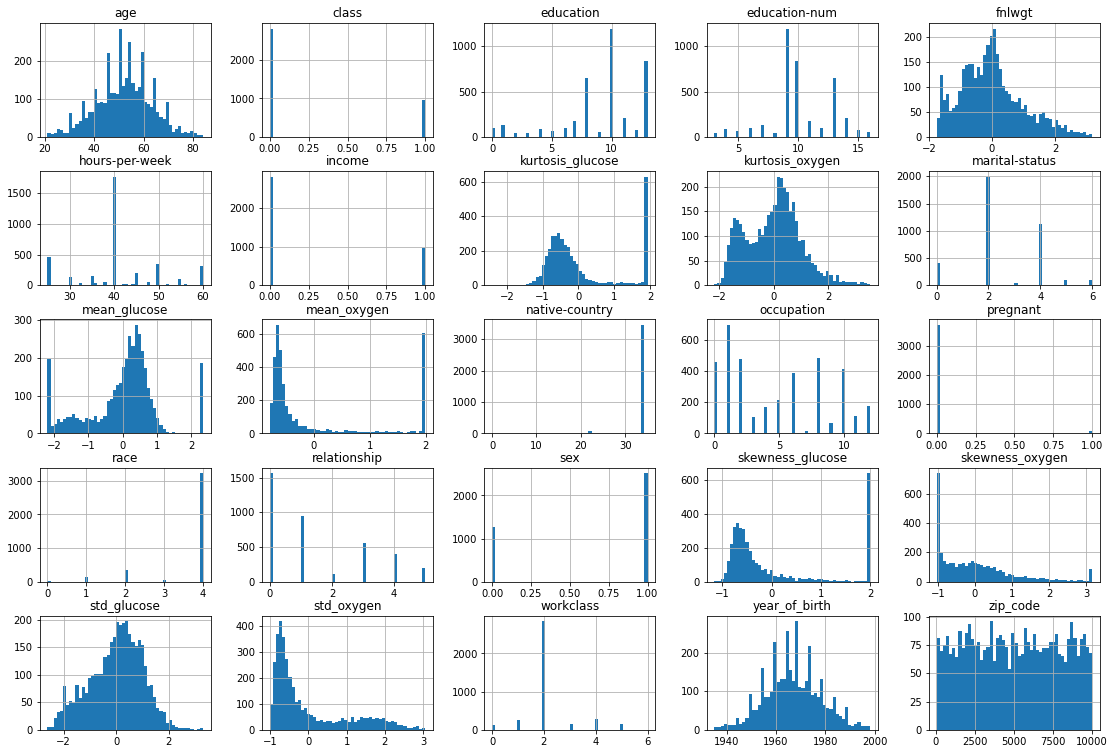

In [18]:
_ = df_train_for_ML.hist(figsize=(19, 13), bins=50)

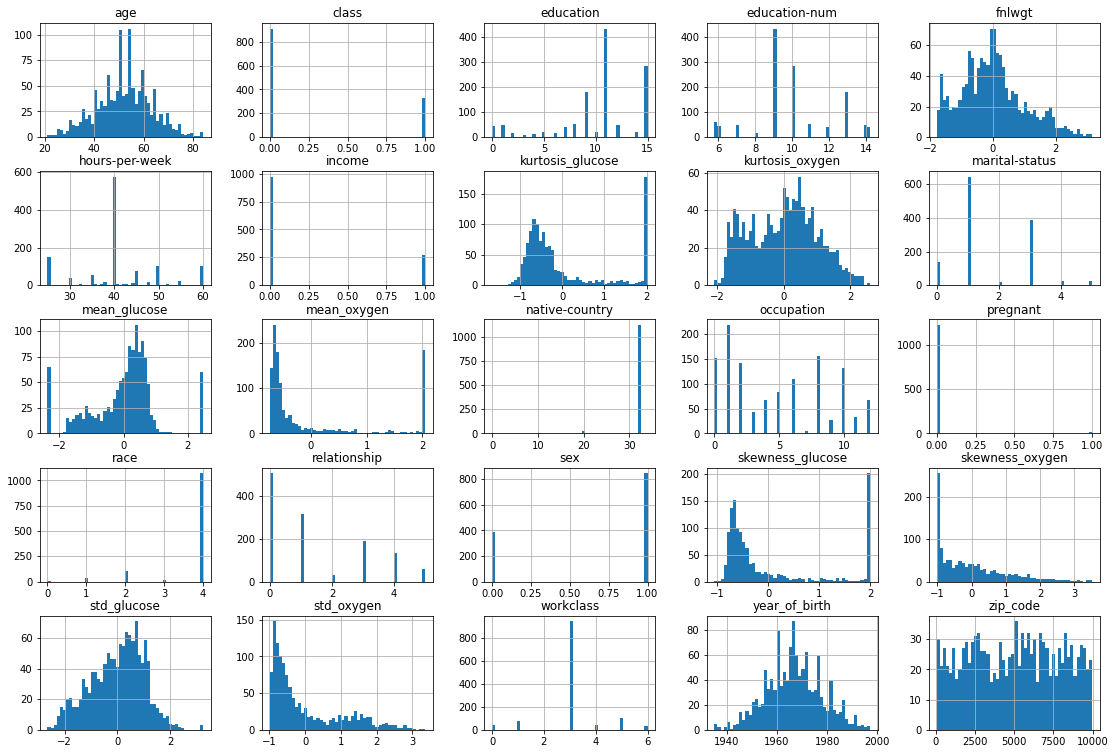

In [19]:
_ = df_valid_for_ML.hist(figsize=(19, 13), bins=50)

In [20]:
df_valid_for_ML['race'].value_counts()

4    1073
2     109
1      36
3      12
0      11
Name: race, dtype: int64

In [21]:
df_valid_joined['race'].value_counts()

White                 1073
Black                  109
Asian-Pac-Islander      36
Other                   12
Amer-Indian-Eskimo      11
Name: race, dtype: int64

In [22]:
df_train_for_ML['race'].value_counts()

4    3234
2     354
1     129
3      35
0      28
Name: race, dtype: int64

In [23]:
df_train_joined['race'].value_counts()

White                 3234
Black                  354
Asian-Pac-Islander     129
Other                   35
Amer-Indian-Eskimo      28
Name: race, dtype: int64

## Záver zo  spracovania
Ako je možné vidieť, tak spracované datasety, ktoré budeme využívať pri trénovaní a testovaní rozhodovacích algoritmov majú skoro rovnaké distribúcie, tým pádom sa nám správne podarilo upraviť obidva datasety. LabelEncoder správne zmenil kategorické atribúty na numerické, pričom sú ich hodnoty v obidvoch datasetoch identické pre rovnaký label.

### Zmena v úprave joinutých datasetov
#### Problém s joinutím datasetov
Ukázalo sa, že joinutý valid dataset obsahuje nepárny počet duplikátov, načo naša DropDuplicates classa nebola pripravená, takže sme museli vyriešiť takýto typ prípadu. Riešenie je implementované všeobecne, bez ohľadu na to aký je počet nepárnych duplikátov. Párny počet duplikátov je stále možné riešiť "starým" spôsobom, tak sme to tak nechali. 

#### Opravený výpočet veku
Predtým sme vypočítali vek osoby pomocou odčítanie roku narodenia od roku 2020. V tejto fáze sme vykonali úpravu, v ktorej z jedného záznamu, ktorý nemám chýbajúce hodnoty pre vek a rok narodenia vypočítame rok, v ktorom boli záznamy vytvorené. Následne v záznamoch, kde chýba vek odpočítame od roku v ktorom boli záznamy vytvorené rok narodenia a dostaneme vek osoby v roku merania.

#### Chyba v class atribúte
Zistili sme, že testovací dataset má jednu chybne nameranú hodnotu pri class. Namiesto 0 alebo 1 to je číslo okolo 0.25. Toto číslo sme zaokrúhlili smerom na dol, aby sme mohli dáta použiť pri vyhodnocovaní natrénovaného modelu.

#### Drop atribútu name
Keď sme menili kategorické atribúty na numerické z dôvodu použitia pre ML, tak sme dropli atribút name, pretože sa  na základe toho nedá určiť, či je pacient chorý alebo nie.

# Manuálne vytvorenie a vyhodnotenie rozhodovacích pravidiel pre klasifikáciu

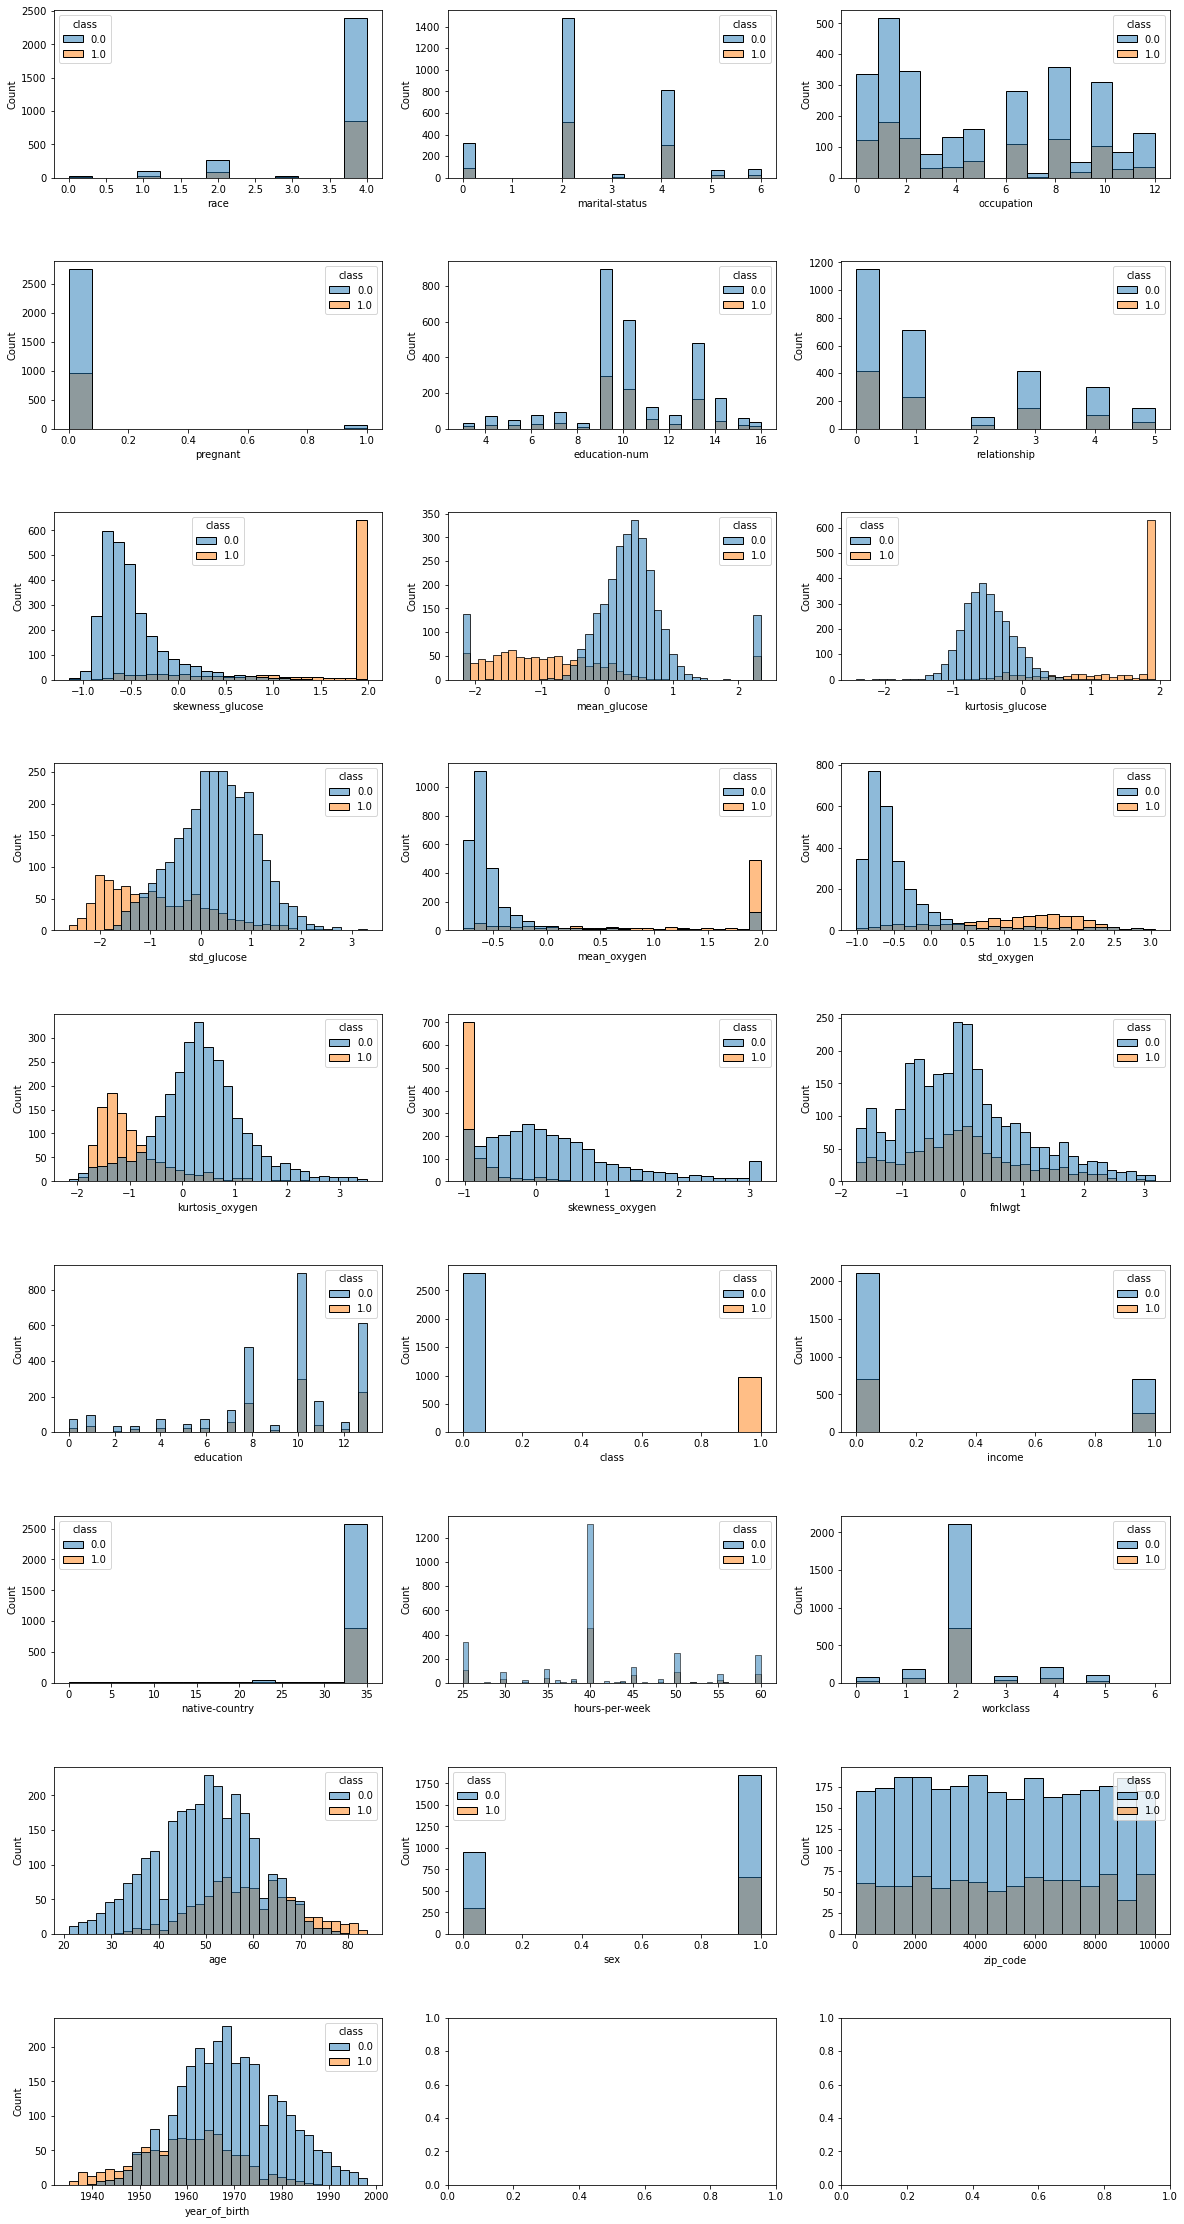

In [24]:
fig, axes = plt.subplots(9, 3, figsize=(20,40))
plt.subplots_adjust(hspace = 0.5)
i = 0
j = 0
for col in df_train_for_ML.columns:
    g1 = sns.histplot(data=df_train_for_ML, ax=axes[i][j], hue="class", x=col)
    j += 1
    if j == 3:
        j = 0
        i += 1

#### Použité pravidlá

Na tvorbu vlasných pravidiel je vhodné použiť medicínske dáta (oxygen a glucose), keďže na nich je najjednoznačnejší rozdiel medzi záznamami prislúchajúcimi chorým a zdravým ľuďom. Dokazjú to aj grafy vyššie. Štyri z piatich pravidiel obsahujú viac atribútov, tie sú spojené logickým and, aby sa pravidlo vyhodnotilo za splnené, musa byť všetky atribúty vyhodnotené ako správne. 
###### Strom použitých pravidiel sa nachádza v priloženom dokumente. 

##### 1. Pravidlo
Prvé pravidlo dokáže hneď identifikovať záznamy, ktoré takmer určite prislúchajú chorým ľuďom. Je tvorené na základe mean_glucose parametru. Pokiaľ sa hodnota mean_glucose nachádza v intervali (-1.05; -2), záznam s veľkou pravdepodobnosťou patrí chorému človeku. Tento interaval nie je ohraničený nekonečnom kvôli výberu outlierov, ktorí síce mali hraničné hodnoty, no i tak boli zdraví. Záznamy, kde sa mean_glucose nenachádza v spomínanom intervali pokračujú k pravidlu 2.

##### 2. Pravidlo
Toto pravidlo sa uplatňuje len na záznamy, ktoré vyhodnotili pravidlo č. 1 ako nepravdivé. Je tvorené na základe parametrov std_oxygen a std_glucose. Pokiaľ je hodnota std_glucose menšia ako -1, je splnená prvá podmienka, aby bol záznam vyhodnotený ako pravdepodobne chorý. To sa môže zdať z grafu vyššie ako dosť benevolentné pravidlo, a preto je ešte upravené ďalším, ktoré tvrdí, že záznam zároveň musí mať hodnotu std_oxygen väčšiu ako 0.5. Takto sa vyfiltrujú tie najviac rizikové záznamy, no treba podotknúť, že žiaden výsledok tohto pravidla ešte nedáva jednoznažný verdikt o zdravotnom stave záznamu, len zvýši jeho pravdepodobnosť byť chorým. 

##### 3. Pravidlo
Ak predchádzajúce pravidlo nie je splnené, nasleduje toto. Keďže pravidlo 2. nebolo splnené, je pravdepodobné, že záznam je zdravý. Ak teda nebude splnené ani 3. pravidlo, záznam sa automaticky určí ako zdravý, pretože je to ešte ešte viac pravdepodobné. Ak platí, vykoná sa ešte jedno pravidlo.
Toto pravidlo je zamerané na parametre kurtosis_glucose a skewness_glucose.  Tieto parametre obsahujú extrémne veľký počet outlierov a takmer každý z nich je chorý. Myslíme si preto, že ak sa záznam nenachádza ani v jednom z týchto extrémov, musí byť určite zdravý a viac pravidiel sa naň už neuplatní. Ak sa záznam nachádza v čo i len  jednom z týchto extrémov, neoznačíme ho rovno ako chorý, nakoľko doteraz bol pravdepodobne zdravý. Vykoná sa teda ešte jedno pravidlo (5), ktoré rozhodne o jeho výsledku. 

##### 4. Pravidlo
Toto pravidlo funguje podobne ako pravidlo 3, s tým rozdielom, že parametrami sú skewness_oxygen a kurtosis_oxygen. Záznamy, ktoré sa dostali k uplatneniu tohto pravidla sú pravdepodobne chorí ľudia. Preto ak budú teraz všetky podmienky splnené, záznam je automaticky vyhodnotený ako chorý. Avšak keď splnené nie sú, rovnako ako v 3. pravidle sa uplatní ešte jedno pravidlo (5). V parametroch skewness_oxygen a kurtosis_oxygen sa síce nenachádza toľko extrémnych outlierov ako v skewness_glucose a kurtosis_glucose, avšak kombinácia oboch sa po pár vyskúšaniach a odhadnutí správneho intervalu osvečila ako vhodná a dokáže záznamy pomerne efektívne rozdeliť na rozhodne zdravé a zvyšné. 
 
##### 5. Pravidlo
Ideálne by sa k tomuto pravidlu nemalo dostať veľa záznamov. Slúži ako definitívny rozhodovací faktor, ktorý funguje na základe veku. Jednoducho, ak je vek väčší ako 30, záznam je označený za chorý, v opačnom prípade za zdravý.

In [34]:
class Node:
    def __init__(self, left, right, rules):
        self.left = left
        self.right = right
        self.rules = rules
        
class Rule:
    def __init__(self, column, splitValue, compareSign):
        self.column = column
        self.splitValue = splitValue
        self.compareSign = compareSign

In [39]:
class MyTree:
    def fit(self):
        self.tree_ = self._grow_tree()

    def _grow_tree(self):
        RuleRoot = [Rule('mean_glucose', -2, '>'), Rule('mean_glucose', -1.05, '<')] # na tutovku chori
        RuleLeft = [Rule('std_glucose', -1, '<'), Rule('std_oxygen', 0.6, '>')]
        RuleLLeft = [Rule('kurtosis_glucose', 0.5, '>'), Rule('skewness_glucose', 0.5, '>')]
        RuleLRight = [Rule('skewness_oxygen', -0.1, '<'), Rule('kurtosis_oxygen', 0, '<')]
        RuleLLR = [Rule('age', 30, '>')]
                
        NodeLLR = Node(None, None, RuleLLR)    
        NodeLeft = Node(Node(None, NodeLLR, RuleLLeft), Node(NodeLLR, None, RuleLRight), RuleLeft) 
        return Node(NodeLeft, None, RuleRoot)
    
    def predict(self, df):
        y = []
        for i, row in df.iterrows():
            y.append(self.result(row))
        return y
    
    def result(self, row):
        currentNode = self.tree_
        while 1:
            if self.applyRules(currentNode.rules, row):
                currentNode = currentNode.right
                if not currentNode:
                    return 1
            else:
                currentNode = currentNode.left
                if not currentNode:
                    return 0
          
    def applyRules(self, rules, row):
        for rule in rules:
            if rule.compareSign == '>':
                if row[rule.column] > rule.splitValue:
                    continue
                else:
                    return 0
            elif rule.compareSign == '<':
                if row[rule.column] < rule.splitValue:
                    continue
                else:
                    return 0
        return 1

In [40]:
myTree = MyTree()
myTree.fit()
y = myTree.predict(df_valid_for_ML) 
print('Accuray: ', metrics.accuracy_score(df_valid_for_ML['class'], y))
print('Precision: ', metrics.precision_score(df_valid_for_ML['class'], y))
print('Recall: ', metrics.recall_score(df_valid_for_ML['class'], y))

Accuray:  0.9443996776792909
Precision:  0.9887640449438202
Recall:  0.8


### Vyhodnotenie manuálne vytvoreného stromu
Náš strom dokazuje 94.4%-nú úspešnosť v klasifikovaní, pričom je 98.9%-ná úspešnosť toho, že je pacient naozaj chorý, keď to náš strom povie, avšak určiť všetkých možných pacientov sa mu moc nedarí, pretože výsledok metriky Recall je 80.0%.
Čo jednotlivé metriky hovoria je presne opísané pri vyhodnocovaní rozhodovacieho stromu z sklearn knižnice.

# Natrénovanie a vyhodnotenie klasifikátora s využitím rozhodovacích stromov

## Trénovanie a vyhodnotenie DecisionTreeClassifier z sklearn knižnice

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

features = ['race', 'marital-status', 'occupation', 'pregnant',
       'education-num', 'relationship', 'skewness_glucose', 'mean_glucose',
       'kurtosis_glucose', 'std_glucose', 'mean_oxygen', 'std_oxygen', 
        'kurtosis_oxygen', 'skewness_oxygen', 'fnlwgt', 'education',
        'income', 'native-country', 'hours-per-week', 'workclass',
        'age', 'sex', 'zip_code', 'year_of_birth']
labels = ['class']

X_train = df_train_for_ML[features]
y_train = df_train_for_ML[labels[0]]

X_test = df_valid_for_ML[features]
y_test = df_valid_for_ML[labels[0]]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy: ', metrics.accuracy_score(y_test, y_pred))
print('Precision: ', metrics.precision_score(y_test, y_pred))
print('Recall: ', metrics.recall_score(y_test, y_pred))

Accuracy:  0.934730056406124
Precision:  0.8830769230769231
Recall:  0.8696969696969697


### Vyhodnotenie natrénovaného rozhodovacieho stromu
Metrika Accuracy hovorí o tom, koľko záznamov bolo správne klasifikovaných bez ohľaduje na to, či sa jedná o klasifikovanie class=0 alebo class=1. Jej výsledok bol 93% a tento rozhodvací strom dosiahol podľa tejto metriky najlepší výsledok.

Metrika Precision hovorí o tom, koľko záznamov, ktoré boli klasifikované našim stromom ako class=1 malo naozaj hodnotu class=1. Jej výsledok je 87%.

Metrika Recall hovorí o tom, koľko záznamov v testovacích dátach má hodnotu class=1 a tento rozhodovací strom ich správne klasifikoval. Výsledok je 86%.

## Vizualizácia natrénovaných pravidiel.

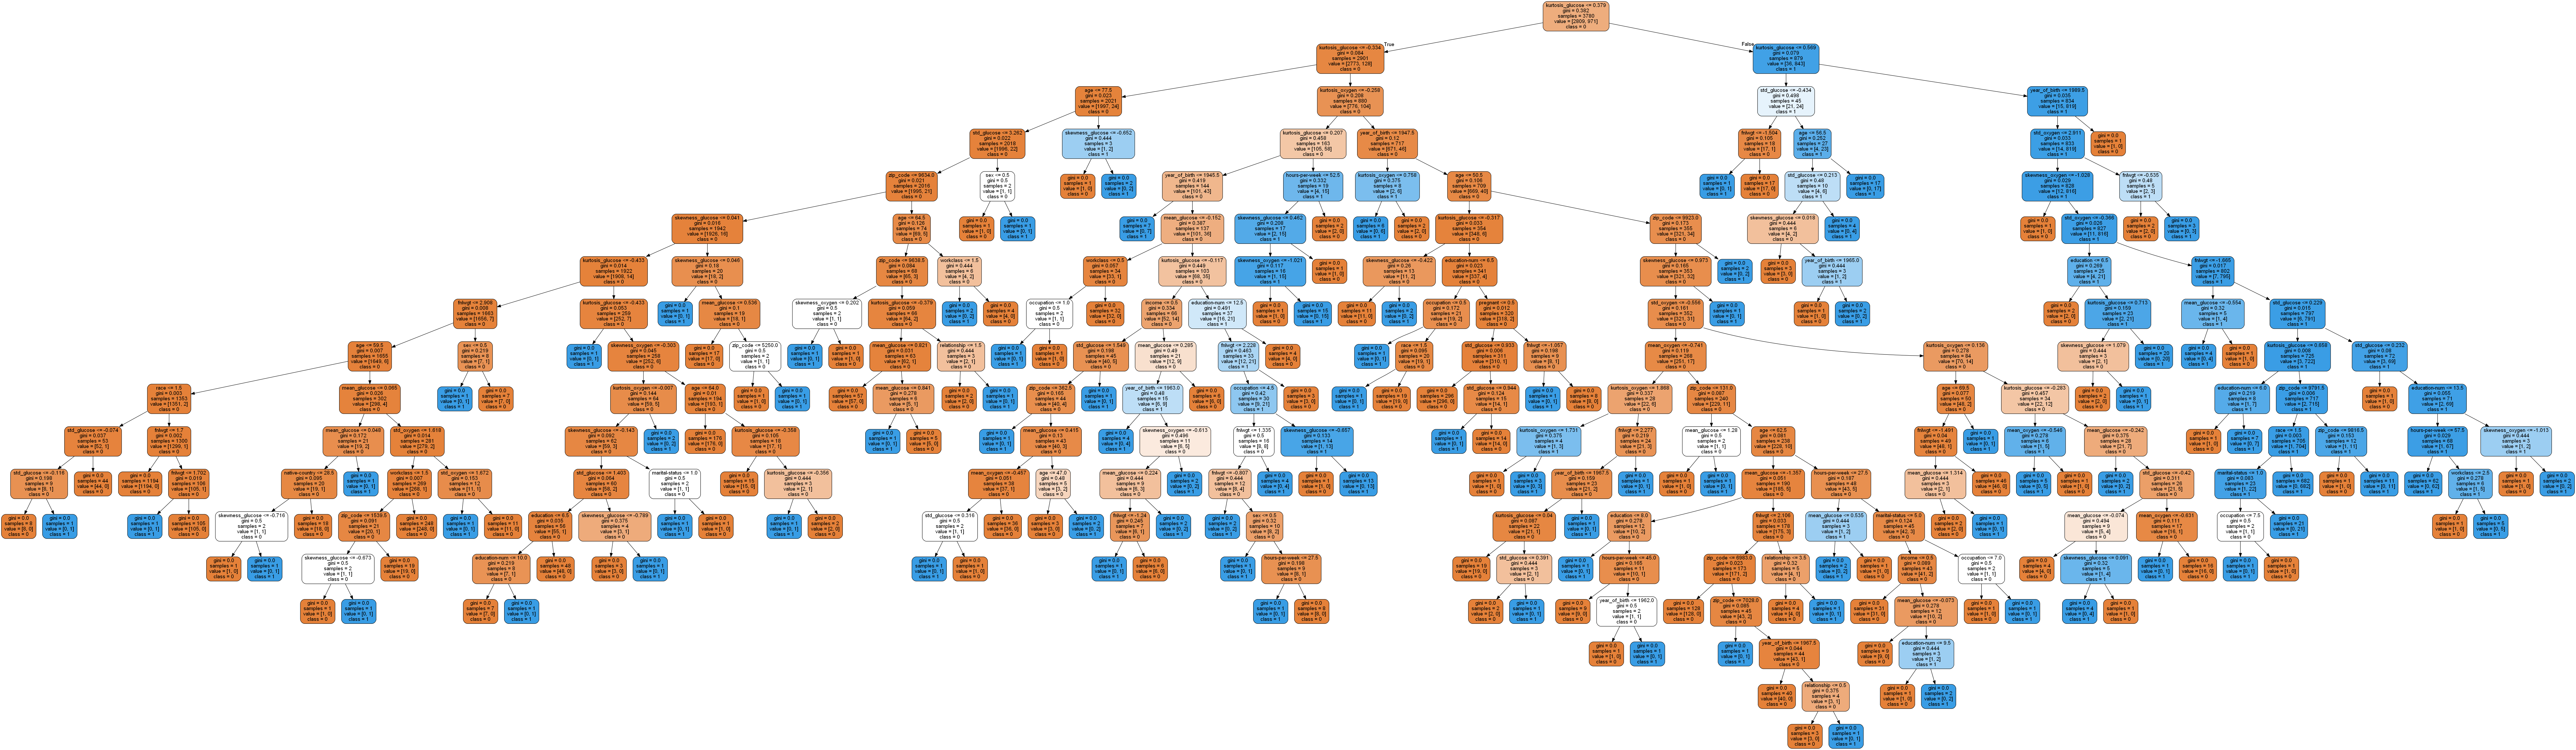

In [29]:
out_file = tree.export_graphviz(clf,
               filled=True, rounded=True,
               feature_names= features,
               class_names=['0', '1'])

graph = pydotplus.graph_from_dot_data(out_file)
Image(graph.create_png())

## Porovnanie natrénovaného klasifikátora z sklearn s našim manuálne vytvoreným stromom

# Optimalizácia hyperparametrov

## Hyperparameter tuning jednotlivých parametrov samostatne

Text(0, 0.5, 'Cross-Validated Accuracy')

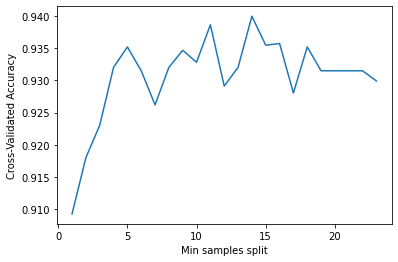

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

X = df_train_for_ML[features]
y = df_train_for_ML[labels[0]]

max_features = range(1, 24)
decision_tree_scores = []

for i in max_features:
    clf = DecisionTreeClassifier(max_features=i)
    scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy').mean()
    decision_tree_scores.append(scores)

plt.plot(max_features, decision_tree_scores)
plt.xlabel('Max features split')

plt.ylabel('Cross-Validated Accuracy')

#### Max features
Na grafe je možné vidieť, že Accuracy natrénovaného stromu od 0 po 5 iba rastie. Následene zhruba od 18 a ďalej iba klesá, takže mohlo prísť k overfittingu.

Text(0, 0.5, 'Cross-Validated Accuracy')

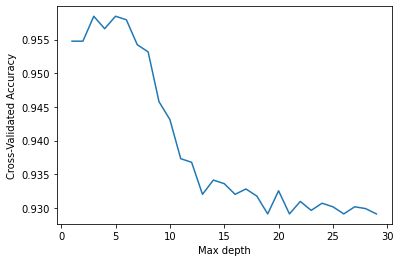

In [31]:
X = df_train_for_ML[features]
y = df_train_for_ML[labels[0]]

max_depth_range = range(1, 30)
decision_tree_scores = []

for i in max_depth_range:
    clf = DecisionTreeClassifier(max_depth=i)
    scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy').mean()
    decision_tree_scores.append(scores)

plt.plot(max_depth_range, decision_tree_scores)
plt.xlabel('Max depth')

plt.ylabel('Cross-Validated Accuracy')

#### Max depth
Ako je možné vidieť, tak accuracy s narastajúcim počtom hĺbky iba klesá, pretože dochádza k overfitovaniu, z tohto dôvodu sme sa rozhodli v rámci GridSearch využiť rozmedzie od 1 po 15 pre tento parameter.

Text(0, 0.5, 'Cross-Validated Accuracy')

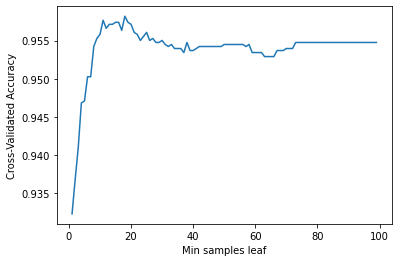

In [32]:
X = df_train_for_ML[features]
y = df_train_for_ML[labels[0]]

min_samples_leaf = range(1, 100)
decision_tree_scores = []

for i in min_samples_leaf:
    clf = DecisionTreeClassifier(min_samples_leaf=i)
    scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy').mean()
    decision_tree_scores.append(scores)

plt.plot(min_samples_leaf, decision_tree_scores)
plt.xlabel('Min samples leaf')

plt.ylabel('Cross-Validated Accuracy')

#### Min samples leaf
Na grafe je možné vidieť, že zhruba pri hodnote 75 parametru min_samples_leaf je výsledok accuracy vždy rovnaký. Cross validácia dokazuje najlepší výsledok niekde v okolí hodnoty 20 načo následene väčšinou iba klesá a občas stúpne. Z tohto dôvodu sme sa rozhodli v rámci GridSearch hyperparameter tuningu použiť pre tento parameter rozmedzie od 10 po 25.

Text(0, 0.5, 'Cross-Validated Accuracy')

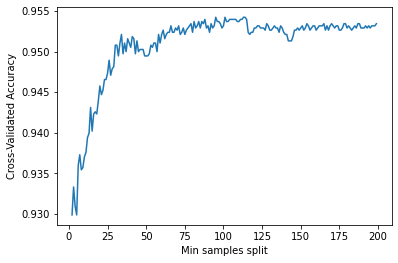

In [37]:
X = df_train_for_ML[features]
y = df_train_for_ML[labels[0]]

min_samples_split = range(2, 200)
decision_tree_scores = []

for i in min_samples_split:
    clf = DecisionTreeClassifier(min_samples_split=i)
    scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy').mean()
    decision_tree_scores.append(scores)

plt.plot(min_samples_split, decision_tree_scores)
plt.xlabel('Min samples split')

plt.ylabel('Cross-Validated Accuracy')

#### Min samples split
Graf nám ukázal, že rozhodovací strom dokazuje najlepšie výsledky zhruba v rozmedziach 75 až 110. Preto v GridSearch použijeme toto rozmedzie v rámci hyperparameter tuning.

## Hyperparameter tuning pomocou GridSearch
Vyberanie parametrov pre proces hyperparameter tuning bolo uskotočnené na základe meraní vyššie. Parameter max_depth interpetuje maximálnu dĺžku do ktorej sa strom môže dostať. 

Parameter max_features hovorí o tom aký maximálny počet features sa použije pri klasifikácii. 

Kritérium podľa ktorého sa strom rozhoduje je uložené v parametri criterion, pričom to môže byť v tomto prípade iba gini a entropy. 

Parameter min_samples_leaf hovorí o tom, koľko samplov je potrebných, aby sme mohli určiť daný node za list v strome. 

Parameter min_samples_split špecifikuje aké minimálne množstvo je potrebné na rozdelenie jedného nodu na pravdivú a nepravdivú vetvu.

### Zvolenie hyperparametrov
Na základe prechádzajúcich meraní sme zvolili rozmedzie max_depth a min_samples_leaf. Keď sme chceli použiť aj parameter min_samples_split, vykonanie GridSearch trvalo extrémne dlho, takže sme ako alternatívu k tomu použili parameter criterion.

In [35]:
X = df_train_for_ML[features]
y = df_train_for_ML[labels[0]]

param_grid = {
    "max_depth": [item for item in range(1, 15)],
    "max_features": [item for item in range(1,24)],
    "min_samples_leaf": [item for item in range(1, 25)],
    "criterion": ["gini", "entropy"]
}

clf = DecisionTreeClassifier()
clf_cv = GridSearchCV(clf, param_grid, cv=10, return_train_score=True)
clf_cv.fit(X, y)

print('Print best score: ', clf_cv.best_score_)
print('Best parametres for this score: ', clf_cv.best_params_)

Print best score:  0.9624338624338623
Best parametres for this score:  {'criterion': 'gini', 'max_depth': 7, 'max_features': 16, 'min_samples_leaf': 14}


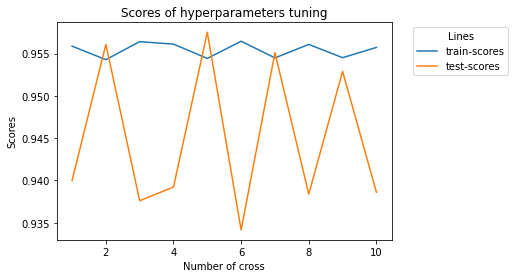

In [36]:
# print(dir(clf_cv))
# print(clf_cv.cv_results_)
mean_test_score = clf_cv.cv_results_.get('mean_test_score')
std_test_score = clf_cv.cv_results_.get('std_test_score')
rank_test_score = clf_cv.cv_results_.get('rank_test_score')

test_scores = [
    np.mean(clf_cv.cv_results_.get('split0_test_score')),
    np.mean(clf_cv.cv_results_.get('split1_test_score')),
    np.mean(clf_cv.cv_results_.get('split2_test_score')),
    np.mean(clf_cv.cv_results_.get('split3_test_score')),
    np.mean(clf_cv.cv_results_.get('split4_test_score')),
    np.mean(clf_cv.cv_results_.get('split5_test_score')),
    np.mean(clf_cv.cv_results_.get('split6_test_score')),
    np.mean(clf_cv.cv_results_.get('split7_test_score')),
    np.mean(clf_cv.cv_results_.get('split8_test_score')),
    np.mean(clf_cv.cv_results_.get('split9_test_score')),
]

train_scores = [
    np.mean(clf_cv.cv_results_.get('split0_train_score')),
    np.mean(clf_cv.cv_results_.get('split1_train_score')),
    np.mean(clf_cv.cv_results_.get('split2_train_score')),
    np.mean(clf_cv.cv_results_.get('split3_train_score')),
    np.mean(clf_cv.cv_results_.get('split4_train_score')),
    np.mean(clf_cv.cv_results_.get('split5_train_score')),
    np.mean(clf_cv.cv_results_.get('split6_train_score')),
    np.mean(clf_cv.cv_results_.get('split7_train_score')),
    np.mean(clf_cv.cv_results_.get('split8_train_score')),
    np.mean(clf_cv.cv_results_.get('split9_train_score')),
]


plt.plot(range(1, 11), train_scores, label='train-scores')
plt.plot(range(1, 11), test_scores, label='test-scores')
plt.title('Scores of hyperparameters tuning')
plt.xlabel('Number of cross')
plt.ylabel('Scores')
plt.legend(title='Lines', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
# print(test_scores)

### Výsledok GridSearchCV
Na grafe je možné vidieť, že vo väčšine prípadov je výsledok trénovania lepší ako testovací. Lenže rozdiel v score nie je až taký velký, tým pádom usudzujeme, že nedošlo k pretrénovaniu.

In [38]:
x_train = df_train_for_ML[features]
y_train = df_train_for_ML[labels[0]]

x_test = df_valid_for_ML[features]
y_test = df_valid_for_ML[labels[0]]

# sklearn_tree = DecisionTreeClassifier(criterion='gini', max_depth=10, max_features=17, min_samples_leaf=10)
sklearn_tree = DecisionTreeClassifier(criterion='gini', max_depth=7, max_features=16, min_samples_leaf=14)
model = sklearn_tree.fit(x_train, y_train)
y_pred = model.predict(x_test)

print('Accuracy: ', metrics.accuracy_score(y_test, y_pred))
print('Precision: ', metrics.precision_score(y_test, y_pred))
print('Recall: ', metrics.recall_score(y_test, y_pred))

Accuracy:  0.9540692989524577
Precision:  0.9534883720930233
Recall:  0.8696969696969697


### Výsledok najlepšieho modelu podľa GridSearchCV
Na testovacích dátam bol výsledok Accuracy zhruba o 1% horší, avšak tento rozhodovací strom si oproti prvému natrénovanovaniu polepšil zhruba o 2%, takže to hodnotíme ako pozitívny výsledok.

# Ďalší gridsearch podľa nových parametrov

V tejto časti sme sa snažili použiť rozmedzie parametrov, ktoré sme odpozorovali na grafoch vyššie. Žial keď sme použili veľkosti rozmedzí, ktoré sme písali pri grafoch jednotlivých parametrov, tak GridSearchCV trval extrémne dlho a ani sa nevykonal z tohoto dôvodu sme museli hranice rozmedzí nejako rozumne okresať.

In [31]:
X = df_train_for_ML[features]
y = df_train_for_ML[labels[0]]

param_grid = {
    "max_depth": [item for item in range(2, 15)],
    "max_features": [item for item in range(5,20)],
    "min_samples_leaf": [item for item in range(10, 25)],
    "min_samples_split": [item for item in range(95, 105)],
}

clf = DecisionTreeClassifier()
clf_cv = GridSearchCV(clf, param_grid, cv=10, return_train_score=True)
clf_cv.fit(X, y)

print('Print best score: ', clf_cv.best_score_)
print('Best parametres for this score: ', clf_cv.best_params_)

Print best score:  0.9603174603174602
Best parametres for this score:  {'max_depth': 14, 'max_features': 11, 'min_samples_leaf': 14, 'min_samples_split': 103}


Výsledok tohto GridSearch je o 0.2% horší ako ten predošlí.

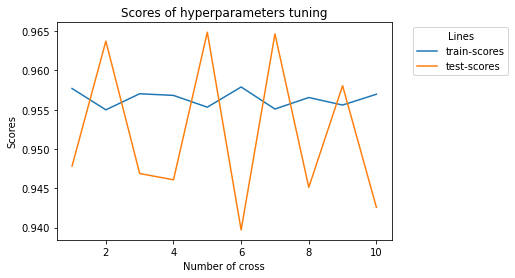

In [32]:
mean_test_score = clf_cv.cv_results_.get('mean_test_score')
std_test_score = clf_cv.cv_results_.get('std_test_score')
rank_test_score = clf_cv.cv_results_.get('rank_test_score')

test_scores = [
    np.mean(clf_cv.cv_results_.get('split0_test_score')),
    np.mean(clf_cv.cv_results_.get('split1_test_score')),
    np.mean(clf_cv.cv_results_.get('split2_test_score')),
    np.mean(clf_cv.cv_results_.get('split3_test_score')),
    np.mean(clf_cv.cv_results_.get('split4_test_score')),
    np.mean(clf_cv.cv_results_.get('split5_test_score')),
    np.mean(clf_cv.cv_results_.get('split6_test_score')),
    np.mean(clf_cv.cv_results_.get('split7_test_score')),
    np.mean(clf_cv.cv_results_.get('split8_test_score')),
    np.mean(clf_cv.cv_results_.get('split9_test_score')),
]

train_scores = [
    np.mean(clf_cv.cv_results_.get('split0_train_score')),
    np.mean(clf_cv.cv_results_.get('split1_train_score')),
    np.mean(clf_cv.cv_results_.get('split2_train_score')),
    np.mean(clf_cv.cv_results_.get('split3_train_score')),
    np.mean(clf_cv.cv_results_.get('split4_train_score')),
    np.mean(clf_cv.cv_results_.get('split5_train_score')),
    np.mean(clf_cv.cv_results_.get('split6_train_score')),
    np.mean(clf_cv.cv_results_.get('split7_train_score')),
    np.mean(clf_cv.cv_results_.get('split8_train_score')),
    np.mean(clf_cv.cv_results_.get('split9_train_score')),
]


plt.plot(range(1, 11), train_scores, label='train-scores')
plt.plot(range(1, 11), test_scores, label='test-scores')
plt.title('Scores of hyperparameters tuning')
plt.xlabel('Number of cross')
plt.ylabel('Scores')
plt.legend(title='Lines', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Výsledok GridSearchCV
Na Grafe je vidieť, že rozdiely vo výsledoch testovanie nie su len horšie, ale aj lepšie, teda usudzujeme, že nedošlo k overfittingu ani underfittingu. 

In [34]:
x_train = df_train_for_ML[features]
y_train = df_train_for_ML[labels[0]]

x_test = df_valid_for_ML[features]
y_test = df_valid_for_ML[labels[0]]

sklearn_tree = DecisionTreeClassifier(criterion='entropy', max_depth=14, max_features=11, min_samples_leaf=14, min_samples_split=103)
model = sklearn_tree.fit(x_train, y_train)
y_pred = model.predict(x_test)

print('Accuracy: ', metrics.accuracy_score(y_test, y_pred))
print('Precision: ', metrics.precision_score(y_test, y_pred))
print('Recall: ', metrics.recall_score(y_test, y_pred))

Accuracy:  0.9629331184528606
Precision:  0.961038961038961
Recall:  0.896969696969697


### Výsledok najlepšieho modelu podľa GridSearchCV
Výsledok najlepšieho modelu sa pri testovaní zlepšil o 0.02%.

## Záver optimalizácie hyperparametrov.
Na začiatku sme pozerali ako sa rozhodovací strom správa pri rôznych rozmedziach jeho parametrov. Na základe výsledok z meraní sme vybrali rozmedzia, ktoré budeme v GridSearchCV použivať, avšak veľkosť týchto rozmedzí bola príliš obrovská, čo spôsobovalo dlhé čakanie, takže sme museli jednotlivé rozmedzia trochu okresať alebo ich napríklad nahradiť iným parametrom ako pri prvom GridSearchCV.

Model z druhého GridSearchCV prehľadávania dokazal pri testovaní lepšie výsledky vo všetkých metrikách. Graf pre tento GridSearchCV zobrazuje, že rozdiely medzi trénovaním a testovaním pri kross validácií nie sú až také veľké a preto usudzujeme, že nedošlo k overfittingu alebo underfittingu, takže tento model považujeme za lepší.

# Vyhodnotenie vplyvu zvolenej stratégie na správnosť klasifikácie
V tejto časti namiesto riešenia chýbajúcich hodnôt pomocou stratégie priemeru pre numerické dáta a stratégie most frequent pre kategorické dáta dropneme všetky chýbajúce hodnoty. Na tento proces bolo potrebné vytvoriť novú classu DropNaNValues, inak bol postup identický s tým ako sme to robili pre hlavnú stratégiu.

In [232]:
class DropNaNValues(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X = X.dropna()

        return X

In [233]:
df_train_drop = df_other_train.merge(df_personal_train, on='name', how='left') # join other train and personal train on name
del df_train_drop['capital-gain']
del df_train_drop['capital-loss']
del df_train_drop['address'] # we can also erase disgusting address column, because we have it in detail from personal train

df_valid_drop = df_other_valid.merge(df_personal_valid, on='name', how='left') # join other train and personal train on name
del df_valid_drop['capital-gain']
del df_valid_drop['capital-loss']
del df_valid_drop['address'] # we can also erase disgusting address column, because we have it in detail from personal train

In [234]:
joined_pipe = Pipeline(steps = [
    ('Drop duplicates', DropDuplicates()),
    ('Extract year', ExtractYear()),
    ('Calculate age from year and drop date_of_birth', CalculateAgeFromYear()),
    ('Drop NaN values', DropNaNValues()),
    ('Get numbers from zip_code and drop city and street', GetNumberFromZipCodeDropCityStreet())
])

df_train_drop = joined_pipe.transform(df_train_drop)
df_valid_drop = joined_pipe.transform(df_valid_drop)

<ipython-input-199-3802d8b28774>:183: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame['year_of_birth'] = years
<ipython-input-199-3802d8b28774>:183: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame['year_of_birth'] = years


In [235]:
df_train_drop = df_train_drop[['name', 'race', 'marital-status', 'occupation', 'pregnant',
       'education-num', 'relationship', 'skewness_glucose', 'mean_glucose',
       'kurtosis_glucose', 'std_glucose', 'mean_oxygen', 'std_oxygen', 
       'kurtosis_oxygen', 'skewness_oxygen', 'fnlwgt', 'education', 'class',
       'income', 'native-country', 'hours-per-week', 'workclass',
       'age', 'sex', 'zip_code', 'year_of_birth']]
df_valid_drop = df_valid_drop[['name', 'race', 'marital-status', 'occupation', 'pregnant',
       'education-num', 'relationship', 'skewness_glucose', 'mean_glucose',
       'kurtosis_glucose', 'std_glucose', 'mean_oxygen', 'std_oxygen', 
       'kurtosis_oxygen', 'skewness_oxygen', 'fnlwgt', 'education', 'class',
       'income', 'native-country', 'hours-per-week', 'workclass',
       'age', 'sex', 'zip_code', 'year_of_birth']]

In [236]:
outliers_pipe = Pipeline(steps = [
    ('Identify medical outliers', IdentifyAndReplaceMedicalOutliers()),
    ('Identify other outliers', IdentifyAndReplaceOtherOutliers())
])

df_train_drop = outliers_pipe.transform(df_train_drop)
df_valid_drop = outliers_pipe.transform(df_valid_drop)

In [237]:
normal_dist_pipe = Pipeline(steps = [
    ('Transform into more normal distribution', Transformation())
])

df_train_drop = normal_dist_pipe.transform(df_train_drop)
df_valid_drop = normal_dist_pipe.transform(df_valid_drop)

In [238]:
df_train_drop_for_ML = transform_categoric_to_numeric(df_train_drop)
df_valid_drop_for_ML = transform_categoric_to_numeric(df_valid_drop)

In [239]:
X_train = df_train_drop_for_ML[features]
y_train = df_train_drop_for_ML[labels[0]]

X_test = df_valid_drop_for_ML[features]
y_test = df_valid_drop_for_ML[labels[0]]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy: ', metrics.accuracy_score(y_test, y_pred))
print('Precision: ', metrics.precision_score(y_test, y_pred))
print('Recall: ', metrics.recall_score(y_test, y_pred))

Accuracy:  0.9384941675503712
Precision:  0.9218106995884774
Recall:  0.8517110266159695


### Výsledok prvej stratégie
Táto stratégia zlepšila výsledok Accuracy o 0.53%, avšak výsledok metriky Precision sa zlepšil zhruba o 4.42%. Výsledok metriky Recall sa zhoršil zhruba o 1.79%. Vzhľadom na to, že táto stratégia mala aj pozitívny, ale aj negatívny vplyv na vyhodnotenie sme sa rozhodli v ďalšej stratégii vyskúšame nepočítať vek ale rovno ho dropnúť.

### Vizualizácia natrénovaného klasifikátora podľa zvolenej stratégie

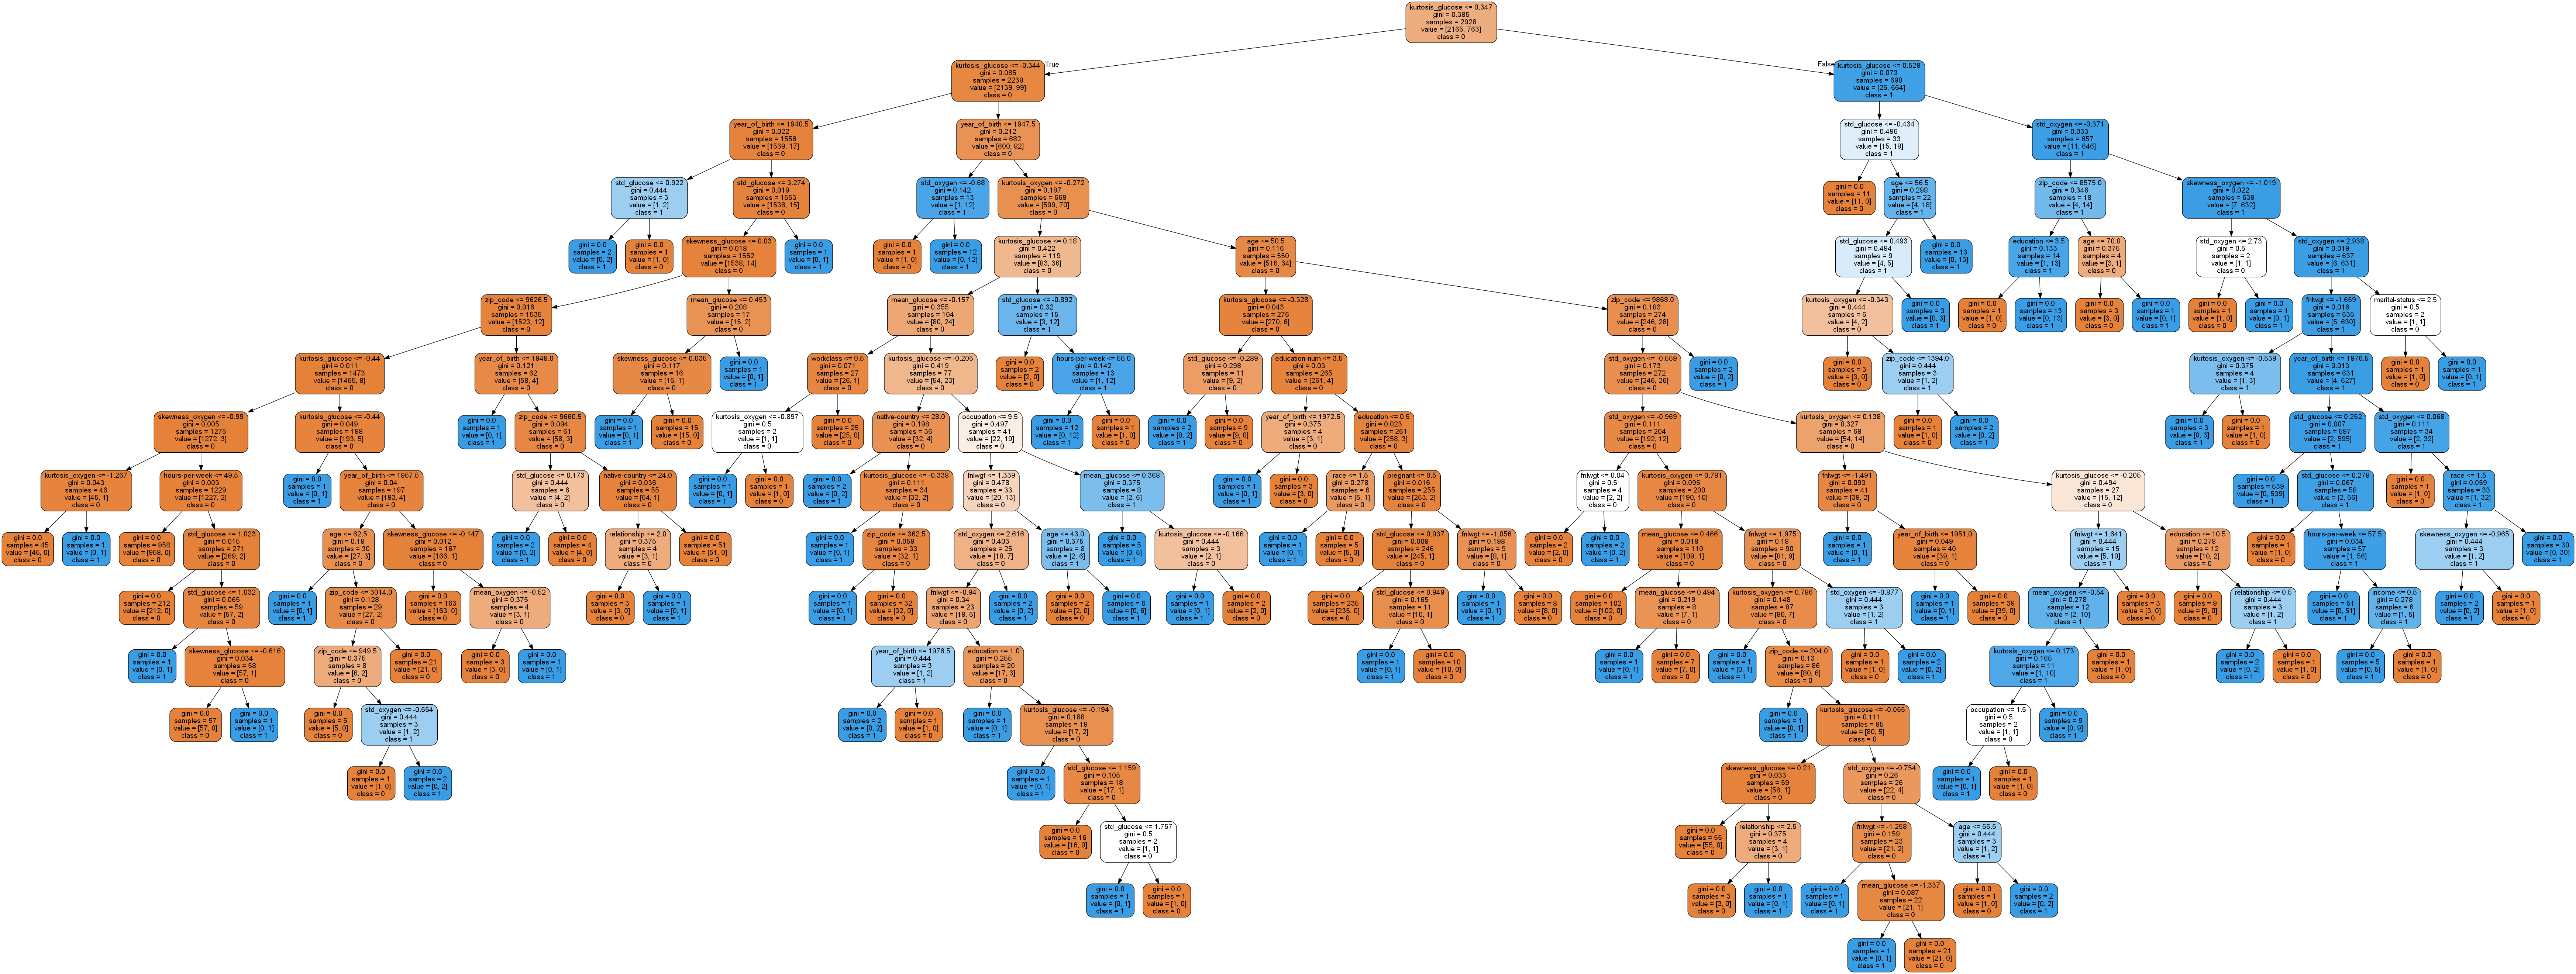

In [240]:
out_file = tree.export_graphviz(clf,
               filled=True, rounded=True,
               feature_names= features,
               class_names=['0', '1'])

graph = pydotplus.graph_from_dot_data(out_file)
Image(graph.create_png())

## Dropovanie všetkých chýbajúcich hodnôt bez kalkulácie veku
Vzhľadom na to, že predošla stratégia nemala veľký dopad na natrénovanie stromu tak sme sa v tejto stratégii rozhodli nevypočítať vek na základe roku narodenia ale chýbajúce hodnoty tohto atribútu dropnúť. V procese spracovania sme namiesto classy CalculateAgeFromYear využili classu DropNaNValues.

In [241]:
df_train_drop = df_other_train.merge(df_personal_train, on='name', how='left') # join other train and personal train on name
del df_train_drop['capital-gain']
del df_train_drop['capital-loss']
del df_train_drop['address'] # we can also erase disgusting address column, because we have it in detail from personal train

df_valid_drop = df_other_valid.merge(df_personal_valid, on='name', how='left') # join other train and personal train on name
del df_valid_drop['capital-gain']
del df_valid_drop['capital-loss']
del df_valid_drop['address'] # we can also erase disgusting address column, because we have it in detail from personal train

In [242]:
joined_pipe = Pipeline(steps = [
    ('Drop duplicates', DropDuplicates()),
    ('Extract year', ExtractYear()),
    ('Drop NaN values', DropNaNValues()),
    ('Get numbers from zip_code and drop city and street', GetNumberFromZipCodeDropCityStreet())
])

df_train_drop = joined_pipe.transform(df_train_drop)
df_valid_drop = joined_pipe.transform(df_valid_drop)

<ipython-input-199-3802d8b28774>:183: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame['year_of_birth'] = years
<ipython-input-199-3802d8b28774>:183: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame['year_of_birth'] = years


In [243]:
df_train_drop = df_train_drop[['name', 'race', 'marital-status', 'occupation', 'pregnant',
       'education-num', 'relationship', 'skewness_glucose', 'mean_glucose',
       'kurtosis_glucose', 'std_glucose', 'mean_oxygen', 'std_oxygen', 
       'kurtosis_oxygen', 'skewness_oxygen', 'fnlwgt', 'education', 'class',
       'income', 'native-country', 'hours-per-week', 'workclass',
       'age', 'sex', 'zip_code', 'year_of_birth']]
df_valid_drop = df_valid_drop[['name', 'race', 'marital-status', 'occupation', 'pregnant',
       'education-num', 'relationship', 'skewness_glucose', 'mean_glucose',
       'kurtosis_glucose', 'std_glucose', 'mean_oxygen', 'std_oxygen', 
       'kurtosis_oxygen', 'skewness_oxygen', 'fnlwgt', 'education', 'class',
       'income', 'native-country', 'hours-per-week', 'workclass',
       'age', 'sex', 'zip_code', 'year_of_birth']]

In [244]:
outliers_normal_dist_pipe = Pipeline(steps = [
    ('Identify medical outliers', IdentifyAndReplaceMedicalOutliers()),
    ('Identify other outliers', IdentifyAndReplaceOtherOutliers()),
    ('Transform into more normal distribution', Transformation())
])

df_train_drop = outliers_normal_dist_pipe.transform(df_train_drop)
df_valid_drop = outliers_normal_dist_pipe.transform(df_valid_drop)

In [245]:
df_train_drop_for_ML = transform_categoric_to_numeric(df_train_drop)
df_valid_drop_for_ML = transform_categoric_to_numeric(df_valid_drop)

In [246]:
X_train = df_train_drop_for_ML[features]
y_train = df_train_drop_for_ML[labels[0]]

X_test = df_valid_drop_for_ML[features]
y_test = df_valid_drop_for_ML[labels[0]]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy: ', metrics.accuracy_score(y_test, y_pred))
print('Precision: ', metrics.precision_score(y_test, y_pred))
print('Recall: ', metrics.recall_score(y_test, y_pred))

Accuracy:  0.951278928136419
Precision:  0.9262672811059908
Recall:  0.8933333333333333


### Výsledok druhej stratégie
Tato stratégia mala pozitivný dopad na metriku Accurary, ktorej výsledok sa zlepšil zhruba o 1.81%. Pričom sa zlepšila aj presnosť klasifikovania záznamov s class=1, pretože Precision dosiahla lepší výsledok zhruba o 4.86% a metrika Recall zhruba o 2.37% oproti pôvodnej stratégii.

## Záver vyhodnotenie vplyvu zvolenej stratégie
Posledná stratégia sa javí ako najlepšie pre tento problém.

### Vizualizácia natrénovaného klasifikátora podľa zvolenej stratégie

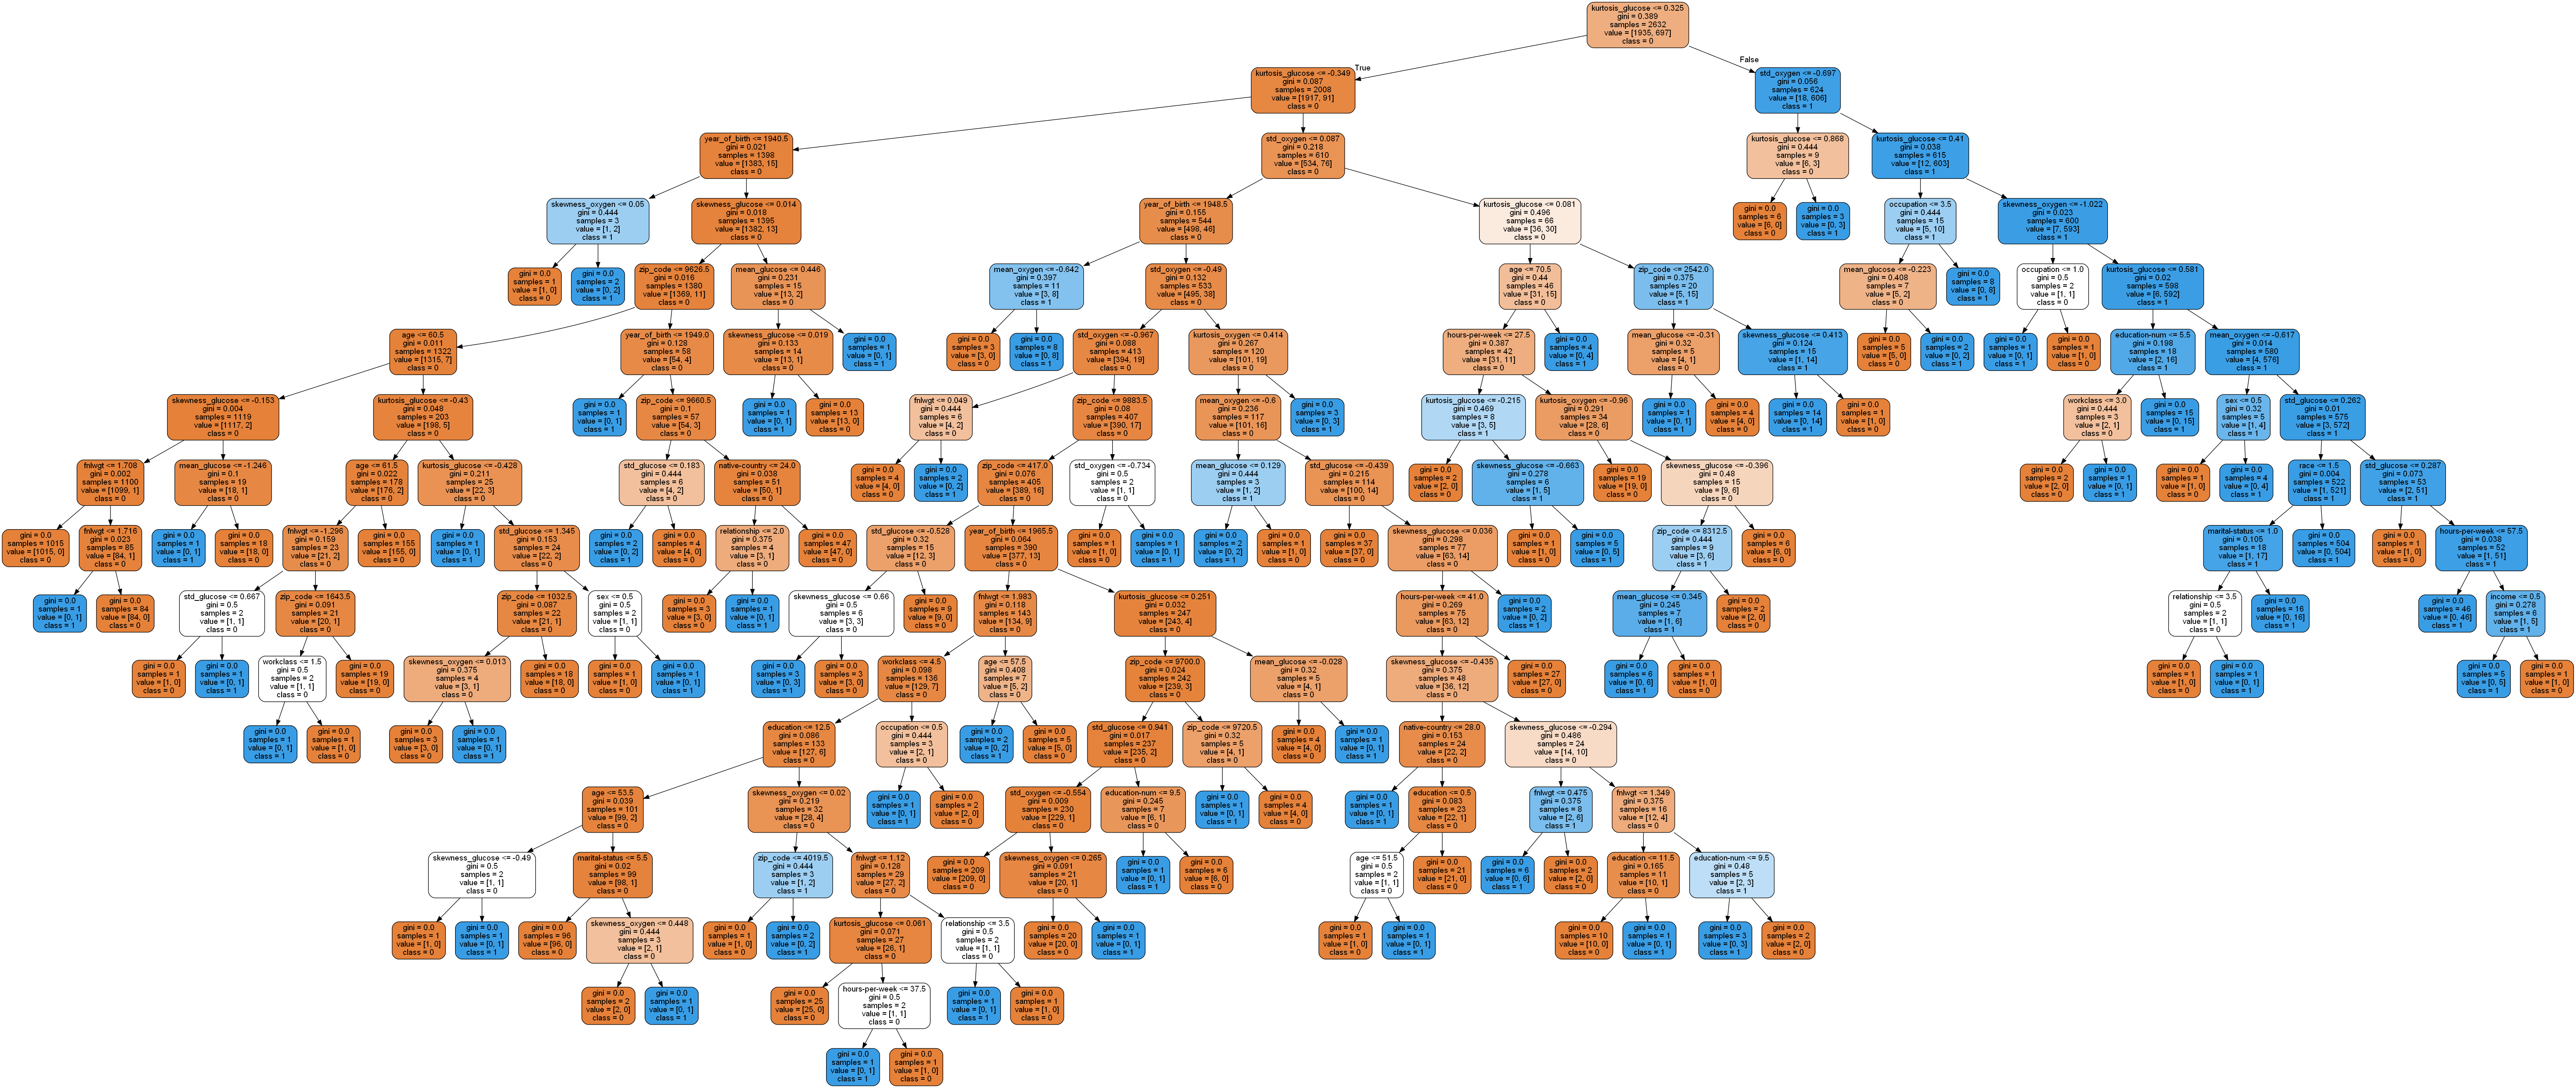

In [247]:
out_file = tree.export_graphviz(clf,
               filled=True, rounded=True,
               feature_names= features,
               class_names=['0', '1'])

graph = pydotplus.graph_from_dot_data(out_file)
Image(graph.create_png())